In [1]:
%matplotlib inline

## description
- this script reads block.det and bim file and create bed file

## motivation
- block structure called by plink does not cover the entire chromosome

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import bisect

In [5]:
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

In [6]:
bim_f = '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic.bim'

In [7]:
bim = pd.read_csv(bim_f, sep='\t', names=['chr', 'rsid', 'genetic_dist', 'pos', 'a1', 'a2'])
print(bim.shape)
bim.tail()

(205378, 6)


,chr,rsid,genetic_dist,pos,a1,a2
205373,20,rs578065922,0,62957957,A,G
205374,20,rs146252638,0,62958306,T,C
205375,20,rs11698187,0,62960292,G,A
205376,20,rs140775622,0,62962869,T,C
205377,20,rs542224338,0,62963102,C,T


- bim file is 1-indexed

In [8]:
block_det_f = '{}/{}'.format(
    '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data',
    'chr20impv1-keep-maf0005-snv-biallelic-block-stronglow050-stronghigh083-infofrac10.blocks.det'
)

In [9]:
block_det = pd.read_csv(block_det_f, sep='\s+')
print(block_det.shape)
block_det.head()

(633, 6)


,CHR,BP1,BP2,KB,NSNPS,SNPS
0,20,62731,93931,31.201,37,rs34147676|rs6139074|rs1418258|rs13043000|rs60...
1,20,94952,266511,171.560,558,rs1857092|rs80192833|rs6052070|rs6515824|rs605...
2,20,266792,286587,19.796,53,rs6137140|rs6082182|rs6082191|rs6082211|rs6075...
3,20,286803,347590,60.788,134,rs75995757|rs6082812|rs7263296|rs6082826|rs116...
4,20,347650,347896,0.247,7,rs6084216|rs78588403|rs77299528|rs75767817|rs7...


In [10]:
np.mean(block_det.KB), np.median(block_det.KB)

(93.5060821484993, 22.959)

In [11]:
np.mean(block_det.NSNPS), np.median(block_det.NSNPS)

(206.67140600315955, 53.0)

In [12]:
block_det.BP1[0], block_det.BP2[len(block_det) - 1], bim.pos[0], bim.pos[len(bim) -1], len(block_det), len(bim)

(62731, 62962869, 61098, 62963102, 633, 205378)

In [13]:
interval_points = np.zeros(len(block_det) + 1, dtype=np.int)
interval_points[1:-1] = block_det.BP1.as_matrix()[1:]
interval_points[0] = bim.pos[0] - 1
interval_points[-1] = bim.pos[len(bim) -1] - 1

In [39]:
bim_pos_0index = bim.pos.map(lambda x: x - 1).as_matrix()
bim_pos_0index

array([   61097,    61269,    61794, ..., 62960291, 62962868, 62963101])

In [45]:
interval_points_bimid = np.array([bisect.bisect_left(bim_pos_0index, x) for x in interval_points])
interval_points_bimid[:10]

array([   0,   86,  938, 1008, 1291, 1303, 1308, 1414, 1505, 1974])

In [46]:
bed_df = pd.DataFrame({
    'chrom': ['chr20'] * len(block_det),
    'chromStart': interval_points[:-1],
    'chromEnd':   interval_points[1:],
    'bimIdStart': interval_points_bimid[:-1],
    'bimIdEnd':   interval_points_bimid[1:]
})

In [50]:
bed_df['name'] = ['{}:{}'.format(bed_df.bimIdStart[x], bed_df.bimIdEnd[x]) for x in range(len(bed_df))]

In [51]:
print(bed_df.shape)
print(bed_df.head())
print(bed_df.tail())

(633, 6)
   bimIdEnd  bimIdStart  chrom  chromEnd  chromStart       name
0        86           0  chr20     94952       61097       0:86
1       938          86  chr20    266792       94952     86:938
2      1008         938  chr20    286803      266792   938:1008
3      1291        1008  chr20    347650      286803  1008:1291
4      1303        1291  chr20    348319      347650  1291:1303
     bimIdEnd  bimIdStart  chrom  chromEnd  chromStart           name
628    202477      201404  chr20  62191558    61992467  201404:202477
629    203822      202477  chr20  62480243    62191558  202477:203822
630    203953      203822  chr20  62516236    62480243  203822:203953
631    205372      203953  chr20  62955706    62516236  203953:205372
632    205377      205372  chr20  62963101    62955706  205372:205377


In [16]:
bed_f = '{}.bed'.format(block_det_f[:-11])
print(bed_f)

/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-block-stronglow050-stronghigh083-infofrac10.bed


In [54]:
bed_df[['chrom', 'chromStart', 'chromEnd', 'name']].to_csv(bed_f, header=False, index=False, sep='\t')

In [55]:
!head $bed_f

chr20	61097	94952	0:86
chr20	94952	266792	86:938
chr20	266792	286803	938:1008
chr20	286803	347650	1008:1291
chr20	347650	348319	1291:1303
chr20	348319	349118	1303:1308
chr20	349118	362067	1308:1414
chr20	362067	381670	1414:1505
chr20	381670	536536	1505:1974
chr20	536536	546178	1974:2029


In [57]:
bed_df['len'] = bed_df.chromEnd - bed_df.chromStart
bed_df['nSNPs'] = bed_df.bimIdEnd - bed_df.bimIdStart

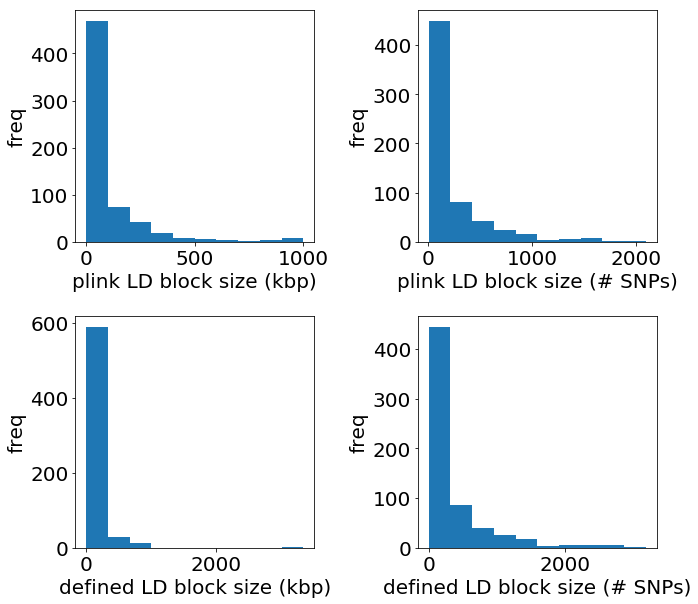

In [59]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
axs = [fig.add_subplot(ss) for ss in gs]
axs[0].hist(block_det.KB)
axs[1].hist(block_det.NSNPS)
axs[2].hist(bed_df.len/1000)
axs[3].hist(bed_df.nSNPs)
axs[0].set_xlabel('plink LD block size (kbp)')
axs[1].set_xlabel('plink LD block size (# SNPs)')
axs[2].set_xlabel('defined LD block size (kbp)')
axs[3].set_xlabel('defined LD block size (# SNPs)')
for ax in axs:
    ax.set_ylabel('freq')
gs.tight_layout(fig, rect=[0, 0, 1, 0.88])

In [60]:
bed_df.sort_values(by='len').head()

,bimIdEnd,bimIdStart,chrom,chromEnd,chromStart,name,len,nSNPs
21,3727,3724,chr20,890096,889869,3724:3727,227,3
491,171528,171523,chr20,54542872,54542622,171523:171528,250,5
95,22385,22374,chr20,5646842,5646531,22374:22385,311,11
584,190319,190314,chr20,59562420,59562077,190314:190319,343,5
92,21748,21744,chr20,5474271,5473898,21744:21748,373,4


In [61]:
bed_df.sort_values(by='len', ascending=False).head()

,bimIdEnd,bimIdStart,chrom,chromEnd,chromStart,name,len,nSNPs
295,95254,94732,chr20,29420066,26062717,94732:95254,3357349,522
310,108016,106563,chr20,35449880,34445164,106563:108016,1004716,1453
297,98087,95811,chr20,30561695,29561238,95811:98087,1000457,2276
306,104213,102545,chr20,33538521,32538391,102545:104213,1000130,1668
294,94732,92052,chr20,26062717,25062715,92052:94732,1000002,2680


In [62]:
np.mean(block_det.KB), np.median(block_det.KB)

(93.5060821484993, 22.959)

In [63]:
np.mean(bed_df.len/1000), np.median(bed_df.len/1000)

(99.37125434439182, 23.962)